In [1]:
from os import listdir
from dotenv import dotenv_values
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

exp_path = '../experiments'
decagon_AUPRC = 0.832
transductive_AUPRC = 0.971
emerGNN_cold = 0.814
emerGNN_warm = 0.906

In [2]:
def load_results(result_filename, exp_path='../experiments', target_len=963*3):
    out = []
    for loc1 in ['MAP4', 'RDK', 'morgan']:
        neighbour_method = loc1
        for loc2 in listdir(f'{exp_path}/{loc1}'):
            nearest_n = int(loc2.split('_n')[-1])
            for loc3 in listdir(f'{exp_path}/{loc1}/{loc2}'):
                if loc3.startswith('2024'):
                    load_path = f'{exp_path}/{loc1}/{loc2}/{loc3}/{result_filename}'
                    df = pd.read_csv(load_path)
                    if len(df) > target_len:
                        df = df.drop_duplicates()
                        assert len(df) == target_len
                        df.to_csv(load_path)
                    df['psi'] = float(loc3.split('psi_')[-1])
                    df['neighbourhood'] = neighbour_method
                    df['nearest_n'] = nearest_n
                    df['Training'] = 'OOS-KGE'
                    out.append(df)
    return out

# Actual PPSE performance by psi value

In [3]:
# Read polySE results using aggregations in place of embeddings
polySE_true_dfs = load_results('polySE_results_real_embeds.csv')

# Also read equivalent results from chapter 3
chap3_path = dotenv_values()['THESIS_PATH'] + '/Chapter3/analysis/assessment/best_trials_assess/20230929-111630-simple_selfloops/results_full.csv'
df_c3 = pd.read_csv(chap3_path)
df_c3['psi'] = 0.0
df_c3['neighbourhood'] = 'N/A (Chap3 results)'
df_c3['nearest_n'] = 'N/A (Chap3 results)'
df_c3['Training'] = 'Standard SimplE'
polySE_true_dfs.append(df_c3)

polySE_true = pd.concat(polySE_true_dfs)
polySE_true

,Relation,AUROC,AUPRC,AP@50,psi,neighbourhood,nearest_n,Training
0,C0005779,0.962682,0.953026,1.000000,0.25,MAP4,5,OOS-KGE
1,C0011991,0.958266,0.940556,0.967104,0.25,MAP4,5,OOS-KGE
2,C0011860,0.968854,0.955512,0.952080,0.25,MAP4,5,OOS-KGE
3,C0038395,0.965226,0.954268,1.000000,0.25,MAP4,5,OOS-KGE
4,C1145670,0.954717,0.936727,0.958807,0.25,MAP4,5,OOS-KGE
...,...,...,...,...,...,...,...,...
958,C0016665,0.995556,0.996028,1.000000,0.00,N/A (Chap3 results),N/A (Chap3 results),Standard SimplE
959,C0006846,0.996618,0.996923,1.000000,0.00,N/A (Chap3 results),N/A (Chap3 results),Standard SimplE
960,C0025637,0.995932,0.995983,0.978775,0.00,N/A (Chap3 results),N/A (Chap3 results),Standard SimplE
961,C0426636,0.996998,0.996954,1.000000,0.00,N/A (Chap3 results),N/A (Chap3 results),Standard SimplE


In [8]:
for tup, subdf in polySE_true.groupby(['psi', 'nearest_n', 'neighbourhood']):
    print(f'At parameters {tup}, median AUPRC = {subdf.AUPRC.median():.5f}')

At parameters (0.125, 5.0, 'MAP4'), median AUPRC = 0.95809
At parameters (0.125, 5.0, 'RDK'), median AUPRC = 0.95811
At parameters (0.125, 5.0, 'morgan'), median AUPRC = 0.95812
At parameters (0.125, 10.0, 'MAP4'), median AUPRC = 0.95898
At parameters (0.125, 10.0, 'RDK'), median AUPRC = 0.95834
At parameters (0.125, 10.0, 'morgan'), median AUPRC = 0.95760
At parameters (0.125, 20.0, 'MAP4'), median AUPRC = 0.95671
At parameters (0.125, 20.0, 'RDK'), median AUPRC = 0.95760
At parameters (0.125, 20.0, 'morgan'), median AUPRC = 0.95779
At parameters (0.25, 5.0, 'MAP4'), median AUPRC = 0.95705
At parameters (0.25, 5.0, 'RDK'), median AUPRC = 0.95791
At parameters (0.25, 5.0, 'morgan'), median AUPRC = 0.95638
At parameters (0.25, 10.0, 'MAP4'), median AUPRC = 0.95700
At parameters (0.25, 10.0, 'RDK'), median AUPRC = 0.95747
At parameters (0.25, 10.0, 'morgan'), median AUPRC = 0.95798
At parameters (0.25, 20.0, 'MAP4'), median AUPRC = 0.95740
At parameters (0.25, 20.0, 'RDK'), median AUPRC 

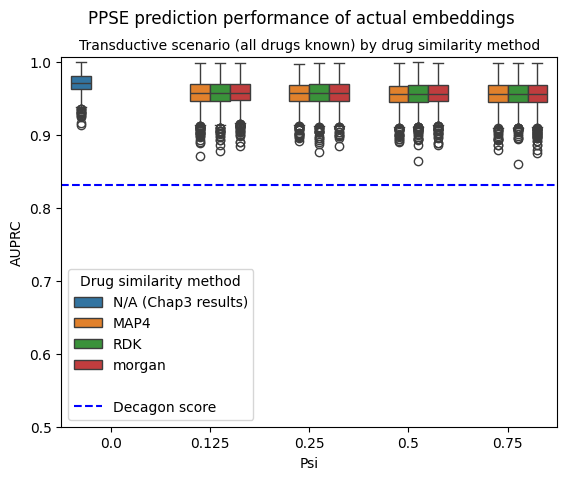

In [35]:
plt.clf()
sns.boxplot(polySE_true, x='psi', y='AUPRC', hue='neighbourhood')
xmin = -0.5
xmax = 4.5

plt.suptitle('PPSE prediction performance of actual embeddings')
plt.title('Transductive scenario (all drugs known) by drug similarity method', size=10)
plt.xlabel('Psi')
plt.ylim(bottom=0.5)
plt.xlim(xmin, xmax)
plt.hlines(10, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')
plt.hlines(decagon_AUPRC, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='Decagon score')
plt.legend(title='Drug similarity method')
plt.savefig('polySE_true_embeds_by_neighbourhood_method.png')

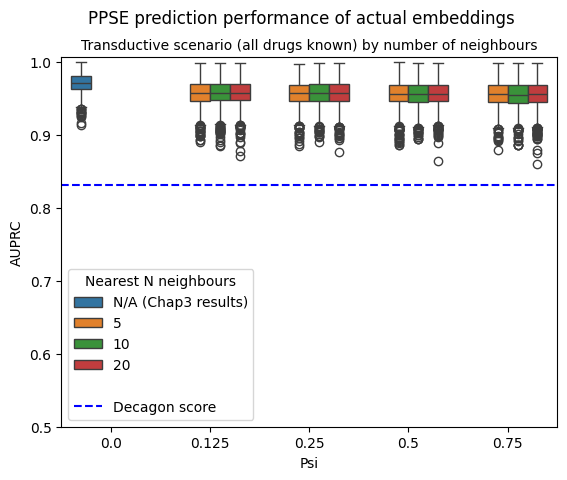

In [36]:
plt.clf()
sns.boxplot(polySE_true, x='psi', y='AUPRC', hue='nearest_n')
xmin = -0.5
xmax = 4.5

plt.suptitle('PPSE prediction performance of actual embeddings')
plt.title('Transductive scenario (all drugs known) by number of neighbours', size=10)
plt.xlabel('Psi')
plt.ylim(bottom=0.5)
plt.xlim(xmin, xmax)
plt.hlines(10, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')
plt.hlines(decagon_AUPRC, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='Decagon score')
plt.legend(title='Nearest N neighbours')
plt.savefig('polySE_true_embeds_by_num_neighbours.png')

# Cosine similarities of aggregated vectors to true embeddings

In [5]:
# Read cosine data
cosine_dfs = load_results('cosines_vs_actual.csv')

# Also read equivalent results from chapter 4
chap4_path = dotenv_values()['THESIS_PATH'] + '/Chapter4/data/results/cosines_vs_actual.csv'
df_c4= pd.read_csv(chap4_path)
df_c4 = df_c4.query('vector_method == "mean components" and neighbourhood_method == "drug similarity"')
df_c4['psi'] = 0.0
df_c4['Training'] = 'Standard SimplE'
df_c4['cosine_to_actual'] = df_c4['cosine_sim']
df_c4['neighbourhood'] = 'N/A (Chap4 results)'
df_c4['nearest_n'] = 'N/A (Chap4 results)'
df_c4.drop(columns=['cosine_sim'], inplace=True)
cosine_dfs.append(df_c4)

cosines = pd.concat(cosine_dfs)
cosines

,drug,neighbourhood_method,vector_method,cosine_to_actual,psi,neighbourhood,nearest_n,Training
0,CID000003954,drug similarity,mean components,0.627120,0.25,MAP4,5,OOS-KGE
1,CID000004829,drug similarity,mean components,0.575273,0.25,MAP4,5,OOS-KGE
2,CID000004140,drug similarity,mean components,0.534625,0.25,MAP4,5,OOS-KGE
3,CID000002909,drug similarity,mean components,0.538957,0.25,MAP4,5,OOS-KGE
4,CID000003676,drug similarity,mean components,0.463523,0.25,MAP4,5,OOS-KGE
...,...,...,...,...,...,...,...,...
5467,CID006435110,drug similarity,mean components,0.717333,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
5479,CID006436173,drug similarity,mean components,0.499533,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
5485,CID006447131,drug similarity,mean components,0.604204,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
5491,CID006918453,drug similarity,mean components,0.588499,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE


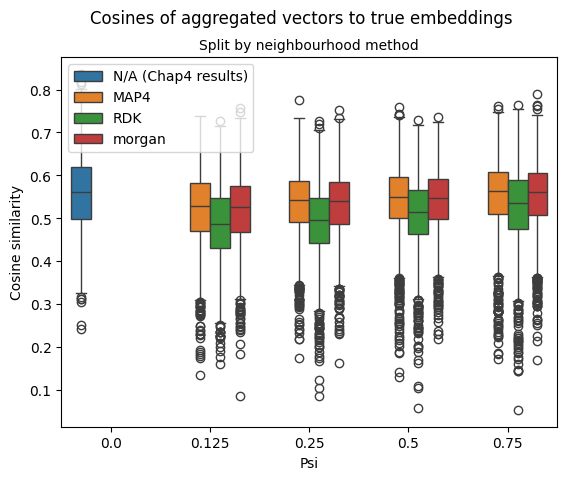

In [10]:
plt.clf()
sns.boxplot(cosines, x='psi', y='cosine_to_actual', hue='neighbourhood')
plt.suptitle('Cosines of aggregated vectors to true embeddings')
plt.title('Split by neighbourhood method', size=10)
plt.xlabel('Psi')
plt.ylabel('Cosine similarity')
plt.legend()
plt.savefig('cosines_vs_actual_by_neighbourhood.png', bbox_inches='tight')

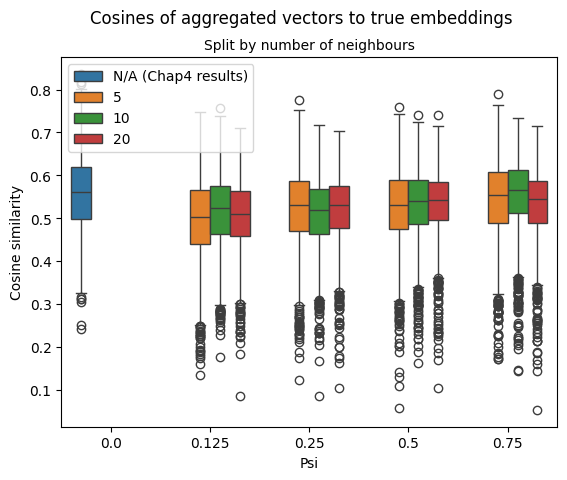

In [11]:
plt.clf()
sns.boxplot(cosines, x='psi', y='cosine_to_actual', hue='nearest_n')
plt.suptitle('Cosines of aggregated vectors to true embeddings')
plt.title('Split by number of neighbours', size=10)
plt.xlabel('Psi')
plt.ylabel('Cosine similarity')
plt.legend()
plt.savefig('cosines_vs_actual_by_num_neighbours.png', bbox_inches='tight')

# PPSE performance using the aggregated vectors

In [44]:
# Read polySE results from using aggregations
polySE_agg_dfs = load_results('polySE_results_aggregations.csv')


# Also read equivalent results from chapter 3
chap4_agg_path = dotenv_values()['THESIS_PATH'] + '/Chapter4/data/results/polySE.csv'
chap4_agg = pd.read_csv(chap4_agg_path)
chap4_agg = chap4_agg.query('vector_method == "mean components" and neighbourhood_method == "drug similarity"')
chap4_agg['psi'] = 0.0
chap4_agg['Training'] = 'Standard SimplE'
chap4_agg['neighbourhood'] = 'N/A (Chap4 results)'
chap4_agg['nearest_n'] = 'N/A (Chap4 results)'
chap4_agg.drop(columns=['neighbourhood_method', 'vector_method'], inplace=True)
polySE_agg_dfs.append(chap4_agg)

polySE_agg = pd.concat(polySE_agg_dfs)
polySE_agg

,side_effect,fake_triple_component,AUROC,AUPRC,AP50,psi,neighbourhood,nearest_n,Training
0,C0000731,head,0.500000,0.500000,0.275912,0.25,MAP4,5,OOS-KGE
1,C0000731,tail,0.500000,0.500000,0.275912,0.25,MAP4,5,OOS-KGE
2,C0000731,both,0.500000,0.500000,0.275912,0.25,MAP4,5,OOS-KGE
3,C0000737,head,0.680286,0.660418,0.530202,0.25,MAP4,5,OOS-KGE
4,C0000737,tail,0.699077,0.690007,0.824252,0.25,MAP4,5,OOS-KGE
...,...,...,...,...,...,...,...,...,...
23080,C0005001,head,0.759702,0.745933,0.902196,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
23081,C0005001,tail,0.841094,0.828883,0.939010,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
23103,C0020625,both,0.568307,0.549721,0.240306,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
23104,C0020625,head,0.790351,0.766044,0.950610,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE


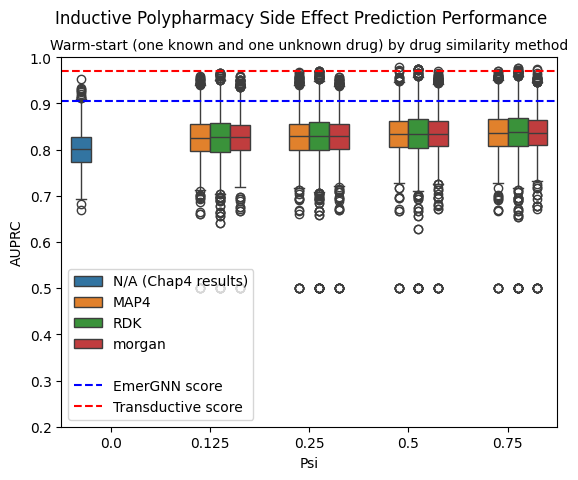

In [45]:
warm_start = polySE_agg.query('fake_triple_component != "both"')
sns.boxplot(warm_start, x='psi', y='AUPRC', hue='neighbourhood')

xmin = -0.5
xmax = 4.5
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_warm, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0.2, 1)
plt.xlim(xmin, xmax)
plt.legend()
plt.suptitle('Inductive Polypharmacy Side Effect Prediction Performance')
plt.title('Warm-start (one known and one unknown drug) by drug similarity method', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.savefig('polySE_agg_warm_start_by_neighbourhood.png')

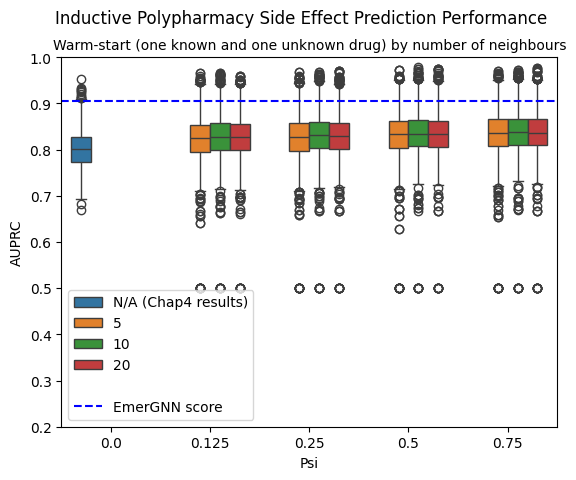

In [46]:
warm_start = polySE_agg.query('fake_triple_component != "both"')
sns.boxplot(warm_start, x='psi', y='AUPRC', hue='nearest_n')

xmin = -0.5
xmax = 4.5
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_warm, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0.2, 1)
plt.xlim(xmin, xmax)
plt.legend()
plt.suptitle('Inductive Polypharmacy Side Effect Prediction Performance')
plt.title('Warm-start (one known and one unknown drug) by number of neighbours', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.savefig('polySE_agg_warm_start_by_num_neighbours.png')

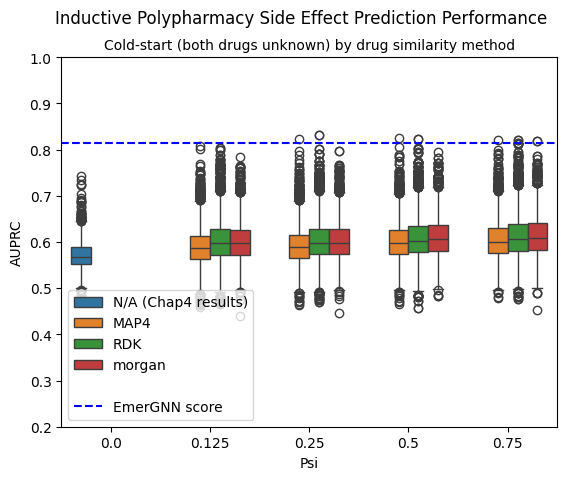

In [47]:
cold_start = polySE_agg.query('fake_triple_component == "both"')
sns.boxplot(cold_start, x='psi', y='AUPRC', hue='neighbourhood')

xmin = -0.5
xmax = 4.5
plt.xlim(xmin, xmax)
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_cold, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0.2, 1.0)
plt.legend()
plt.suptitle('Inductive Polypharmacy Side Effect Prediction Performance')
plt.title('Cold-start (both drugs unknown) by drug similarity method', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.savefig('polySE_agg_cold_start_by_neighbourhood.png')

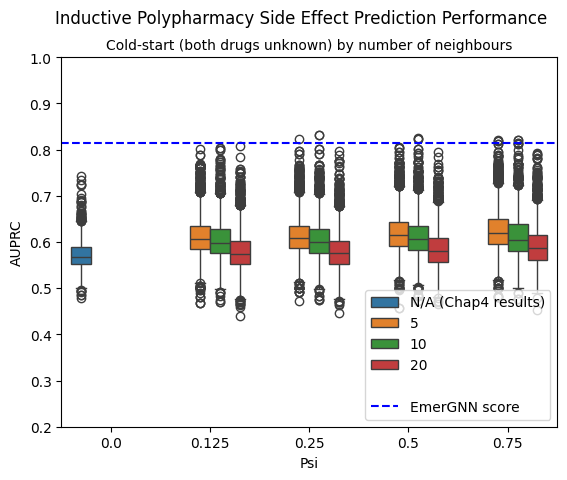

In [48]:
cold_start = polySE_agg.query('fake_triple_component == "both"')
sns.boxplot(cold_start, x='psi', y='AUPRC', hue='nearest_n')

xmin = -0.5
xmax = 4.5
plt.xlim(xmin, xmax)
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_cold, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0.2, 1.0)
plt.legend()
plt.suptitle('Inductive Polypharmacy Side Effect Prediction Performance')
plt.title('Cold-start (both drugs unknown) by number of neighbours', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.savefig('polySE_agg_cold_start_by_num_neighbours.png')

# Bits of analysis for paper and stuff

In [22]:
warm_OOS = polySE_agg.query('Training != "Standard LibKGE training" and fake_triple_component != "both"')
warm_standard = polySE_agg.query('Training == "Standard LibKGE training" and fake_triple_component != "both"')

print('Warm start: chapter 4 vs chapter 5:\n')
print(f'Standard LibKGE median AUPRC = {warm_standard.AUPRC.median()}')
for psi, subdf in warm_OOS.groupby('psi'):
    print(f'OOS psi = {psi}, median AUPRC = {subdf.AUPRC.median()}')

Warm start: chapter 4 vs chapter 5:

Standard LibKGE median AUPRC = 0.8005534279019861
OOS psi = 0.125, median AUPRC = 0.8400505352496238
OOS psi = 0.25, median AUPRC = 0.8455373821665053
OOS psi = 0.5, median AUPRC = 0.8526778016622881
OOS psi = 0.75, median AUPRC = 0.8553088548295023


In [23]:
cold_OOS = polySE_agg.query('Training != "Standard LibKGE training" and fake_triple_component == "both"')
cold_standard = polySE_agg.query('Training == "Standard LibKGE training" and fake_triple_component == "both"')


print('Cold start: chapter 4 vs chapter 5:\n')
print(f'Standard LibKGE median AUPRC = {cold_standard.AUPRC.median()}')
for psi, subdf in cold_OOS.groupby('psi'):
    print(f'OOS psi = {psi}, median AUPRC = {subdf.AUPRC.median()}')

Cold start: chapter 4 vs chapter 5:

Standard LibKGE median AUPRC = 0.5678348031246792
OOS psi = 0.125, median AUPRC = 0.6136335087204419
OOS psi = 0.25, median AUPRC = 0.6145371572966042
OOS psi = 0.5, median AUPRC = 0.6165419431076511
OOS psi = 0.75, median AUPRC = 0.6196297142239998


# Runtime analysis

In [50]:
# Load OOS experiment runtimes

runtimes_list = load_results('epoch_runtimes.csv')

runtimes = pd.concat(runtimes_list)
runtimes['Training'] = "OOS-KGE"
runtimes

,epoch,runtime,psi,neighbourhood,nearest_n,Training
0,1,367.916080,0.250,MAP4,5,OOS-KGE
1,2,373.009232,0.250,MAP4,5,OOS-KGE
2,3,368.799942,0.250,MAP4,5,OOS-KGE
3,4,370.225601,0.250,MAP4,5,OOS-KGE
4,5,371.512388,0.250,MAP4,5,OOS-KGE
...,...,...,...,...,...,...
45,46,510.682148,0.125,morgan,10,OOS-KGE
46,47,510.549377,0.125,morgan,10,OOS-KGE
47,48,519.018309,0.125,morgan,10,OOS-KGE
48,49,522.089859,0.125,morgan,10,OOS-KGE


In [52]:
# Load standard experiment runtimes
chap3_runtimes = pd.read_csv('../../../Chapter3/analysis/experiments/runtimes/per_epoch_runtimes.csv')

# Best checkpoint was SimplE model on selfloops dataset, trial 21 epoch 480
chap3_runtimes.query('dataset == "selfloops" and model == "simple" and trial == 21 and epoch <= 480', inplace=True)
chap3_runtimes = chap3_runtimes[['epoch', 'runtime']]
chap3_runtimes['psi'] = 0.0
chap3_runtimes['nearest_n'] = 'N/A (Chap4 results)'
chap3_runtimes['neighbourhood'] = 'N/A (Chap4 results)'
chap3_runtimes['Training'] = "Standard SimplE"

runtimes = pd.concat([runtimes, chap3_runtimes])
runtimes

,epoch,runtime,psi,neighbourhood,nearest_n,Training
0,1,367.916080,0.25,MAP4,5,OOS-KGE
1,2,373.009232,0.25,MAP4,5,OOS-KGE
2,3,368.799942,0.25,MAP4,5,OOS-KGE
3,4,370.225601,0.25,MAP4,5,OOS-KGE
4,5,371.512388,0.25,MAP4,5,OOS-KGE
...,...,...,...,...,...,...
20047,476,117.971051,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
20048,477,118.652947,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
20049,478,118.595423,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE
20050,479,118.569252,0.00,N/A (Chap4 results),N/A (Chap4 results),Standard SimplE


/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_8566/3763153949.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(runtimes, x='psi', y='runtime', hue='neighbourhood', ci='sd')


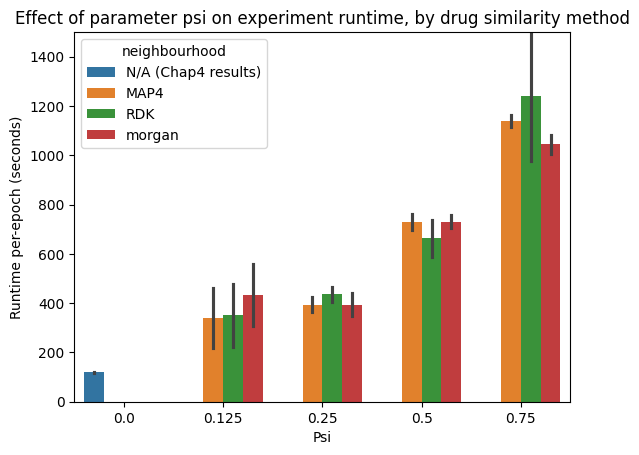

In [53]:
sns.barplot(runtimes, x='psi', y='runtime', hue='neighbourhood', ci='sd')
plt.ylim(0, 1500)
plt.xlabel('Psi')
plt.ylabel('Runtime per-epoch (seconds)')
plt.title('Effect of parameter psi on experiment runtime, by drug similarity method')
plt.savefig('runtime_vs_chap3_by_neighbourhood.png')

/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_8566/2645220498.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(runtimes, x='psi', y='runtime', hue='nearest_n', ci='sd')


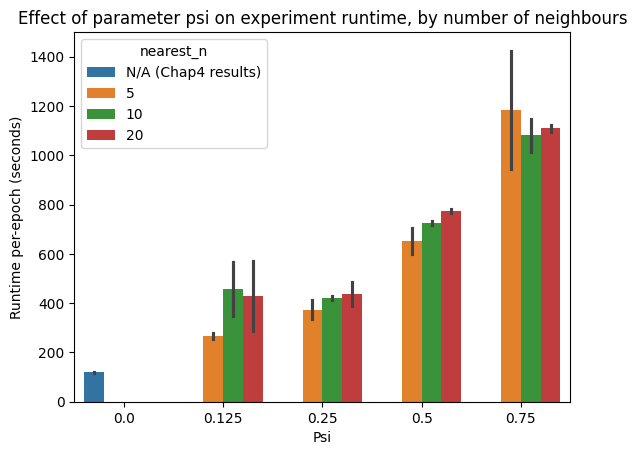

In [55]:
sns.barplot(runtimes, x='psi', y='runtime', hue='nearest_n', ci='sd')
plt.ylim(0, 1500)
plt.xlabel('Psi')
plt.ylabel('Runtime per-epoch (seconds)')
plt.title('Effect of parameter psi on experiment runtime, by number of neighbours')
plt.savefig('runtime_vs_chap3_by_num_neighbours.png')

# Post hoc node removal analysis

In [5]:
ad_hoc = pd.concat(load_results('polySE_results_aggregations.csv'))
post_hoc = pd.concat(load_results('polySE_posthoc_results_aggregations.csv'))

In [6]:
ad_hoc

,side_effect,fake_triple_component,AUROC,AUPRC,AP50,psi,neighbourhood,nearest_n,Training,Unnamed: 0
0,C0000731,head,0.500000,0.500000,0.275912,0.250,MAP4,5,OOS-KGE,NaN
1,C0000731,tail,0.500000,0.500000,0.275912,0.250,MAP4,5,OOS-KGE,NaN
2,C0000731,both,0.500000,0.500000,0.275912,0.250,MAP4,5,OOS-KGE,NaN
3,C0000737,head,0.680286,0.660418,0.530202,0.250,MAP4,5,OOS-KGE,NaN
4,C0000737,tail,0.699077,0.690007,0.824252,0.250,MAP4,5,OOS-KGE,NaN
...,...,...,...,...,...,...,...,...,...,...
2884,C1527407,tail,0.912722,0.912791,0.795676,0.125,morgan,10,OOS-KGE,NaN
2885,C1527407,both,0.573595,0.586128,0.357774,0.125,morgan,10,OOS-KGE,NaN
2886,C1621958,head,0.900635,0.896511,0.814186,0.125,morgan,10,OOS-KGE,NaN
2887,C1621958,tail,0.857422,0.839670,0.717360,0.125,morgan,10,OOS-KGE,NaN


In [7]:
post_hoc

,side_effect,fake_triple_component,AUROC,AUPRC,AP50,psi,neighbourhood,nearest_n,Training
0,C0000731,head,0.506489,0.505867,0.311238,0.250,MAP4,5,OOS-KGE
1,C0000731,tail,0.509745,0.508317,0.323840,0.250,MAP4,5,OOS-KGE
2,C0000731,both,0.502406,0.499237,0.275273,0.250,MAP4,5,OOS-KGE
3,C0000737,head,0.684724,0.665254,0.576091,0.250,MAP4,5,OOS-KGE
4,C0000737,tail,0.704312,0.694541,0.822856,0.250,MAP4,5,OOS-KGE
...,...,...,...,...,...,...,...,...,...
2884,C1527407,tail,0.909231,0.912791,0.795676,0.125,morgan,10,OOS-KGE
2885,C1527407,both,0.576154,0.593728,0.370941,0.125,morgan,10,OOS-KGE
2886,C1621958,head,0.900635,0.896511,0.814186,0.125,morgan,10,OOS-KGE
2887,C1621958,tail,0.857422,0.839670,0.717360,0.125,morgan,10,OOS-KGE


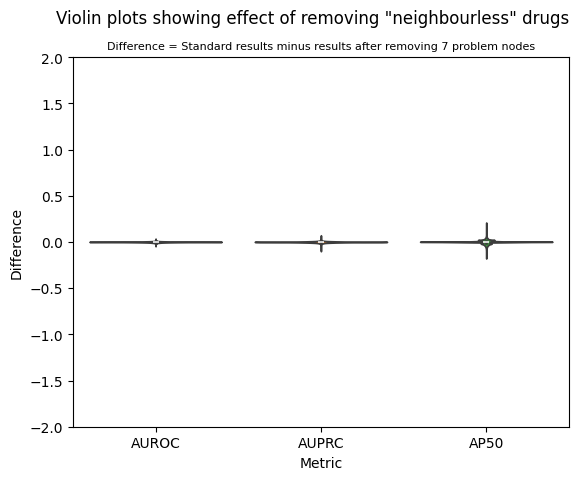

In [9]:
metrics = ['AUROC','AUPRC', 'AP50']
diff = ad_hoc[metrics] - post_hoc[metrics]

sns.violinplot(diff)
plt.ylim(-2, 2)
plt.xlabel('Metric')
plt.ylabel('Difference')
plt.suptitle('Violin plots showing effect of removing "neighbourless" drugs')
plt.title('Difference = Standard results minus results after removing 7 problem nodes', size=8)
plt.savefig('posthoc_difference.png')

In [12]:
abs_diff = np.abs(diff)
print('AUROC median:', abs_diff.AUROC.median())
print('AUPRC median:', abs_diff.AUPRC.median())
print('AP50 median:', abs_diff.AP50.median())


AUROC median: 0.002019468042842143
AUPRC median: 0.002657847733591401
AP50 median: 0.002852849782172928
